In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [67]:
# load data
train_data = unpickle('data/cifar-10-batches-py/data_batch_1')
test_data = unpickle('data/cifar-10-batches-py/test_batch')
train, train_labels = train_data[b'data'], train_data[b'labels']
test, test_labels = test_data[b'data'], test_data[b'labels']
data_meta = unpickle('data/cifar-10-batches-py/batches.meta')
label_name = {i: data_meta[b'label_names'][i] for i in range(10)}

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

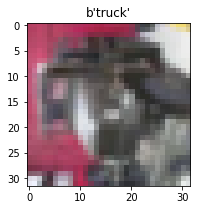

In [101]:
# visualize cifar-10 images
i = np.random.randint(len(train))
x = train[i].reshape(32, 32, 3, order='F')
fig = plt.figure(figsize=(3, 3))
plt.title(label_name[train_labels[i]])
plt.imshow(x)

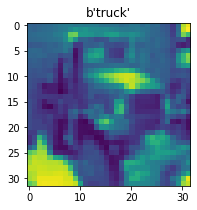

In [102]:
# turn into gray scale image using Luma coding
train_gray = 0.2989 * train[:, :1024] + 0.5870 * train[:, 1024:2048] + 0.1140 * train[:, -1024:]

# visualize cifar-10 images
x = train_gray[i].reshape(32, 32)
fig = plt.figure(figsize=(3, 3))
plt.title(label_name[train_labels[i]])
plt.imshow(x)

In [103]:
def gabor_kernel_matrix(N, t, l, m):
    x = np.arange(np.sqrt(N))
    yy, xx = np.meshgrid(x, x)
    grid = np.column_stack((xx.flatten(), yy.flatten()))
    
    a = squareform(pdist(grid, 'sqeuclidean'))
    b = la.norm(grid - m, axis=1) ** 2
    c = b.reshape(-1, 1)
    K = 10 * np.exp(-a / (2 * l ** 2)) * np.exp(-b / (2 * t ** 2)) * np.exp(-c / (2 * t ** 2))
    K += 1e-5 * np.eye(N)
    return K

def gabor_random_features_for_center(M, N, t, l, m):
    K = gabor_kernel_matrix(N, t, l, m)
    L = np.linalg.cholesky(K)
    w = np.dot(L, np.random.randn(N, M))
    return w

def gabor_random_features(M, N, t, l, n_centers=80):
    centers = np.random.randint(int(np.sqrt(N)), size=(n_centers, 2))

    W = np.empty(shape=(0, N))
    for m in centers:
        w = gabor_random_features_for_center(M, N, t, l, m)
        W = np.row_stack((W, w.T))
    return W

In [ ]:
from sklearn.model_selection import train_test_split